In [1]:
import json
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
import regex as re

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\steve\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Funciones para armar el dataset

In [2]:
import os
def get_hashtags_text(x):
    if pd.notna(x) and 'hashtags' in x and x['hashtags']:
        hashtags = x['hashtags']
        hashtags_text = [ht['text'] for ht in hashtags]
        return hashtags_text
    else:
        return None

def get_urls(x):
    if pd.notna(x) and 'urls' in x and x['urls']:
        return True
    return False


def get_user_location(x):
    if pd.notna(x) and 'location' in x:
        return x['location']
    else:
        return None


def load_json(file_path):
    df_new = pd.DataFrame()

    try:
        # Leer el archivo JSON línea por línea y cargar los datos en una lista
        datos_json = []
        with open(file_path, "r", encoding="utf-8") as f:
            for line in f:
                data = json.loads(line)
                if 'retweeted_status' in data and data['retweeted_status'] != None:
                    data = data['retweeted_status']
                datos_json.append(data)

        df = pd.DataFrame(datos_json)

        df_new['id'] = df['id']
        df_new['lang'] = df['lang']
        df_new['text'] = df['text']
        df_new['favorite_count'] = df['favorite_count']
        df_new['retweet_count'] = df['retweet_count']
        df_new['possibly_sensitive'] = df['possibly_sensitive']
        df_new['created_at'] = df['created_at']
        df_new['is_quote_status'] = df['is_quote_status']
        df_new['entities_hashtags_text'] = df['entities'].apply(get_hashtags_text)
        df_new['entities_urls'] = df['entities'].apply(get_urls)
        df_new['user_location'] = df['user'].apply(get_user_location)
        
        # Asignar 0 a las columnas 'reply_count' y 'quote_count' si no existen
        df_new['reply_count'] = df.get('reply_count', 0)
        df_new['quote_count'] = df.get('quote_count', 0)

        # Verificar si hay al menos una imagen en el JSON
        has_image = []
        for i in range(len(df)):
            try:
                extended_entities = df['extended_entities'][i]
                if 'media' in extended_entities and len(extended_entities['media']) > 0:
                    has_image.append(True)
                else:
                    has_image.append(False)
            except (KeyError, TypeError):
                has_image.append(False)

        df_new['has_image'] = has_image

    except Exception as e:
        print(f'Se produjo una excepción: {e}')

    # Retornar el DataFrame resultante
    return df_new


def load_jsons_from_folder(folder_path):
    df_all = pd.DataFrame()

    try:
        # Obtener la lista de archivos en la carpeta
        json_files = [f for f in os.listdir(folder_path) if f.endswith('.json')]

        for file_name in json_files:
            file_path = os.path.join(folder_path, file_name)
            df = load_json(file_path)

            # Extraer el nombre del archivo sin "_final_data.json"
            json_name = file_name.replace('_final_data.json', '')

            # Agregar columna con el nombre del JSON
            df['json_name'] = json_name

            # Concatenar el DataFrame al DataFrame total
            df_all = pd.concat([df_all, df], ignore_index=True)

    except Exception as e:
        print(f'Se produjo una excepción: {e}')

    # Retornar el DataFrame resultante
    return df_all

def read_tsv_folder(folder_path):
    df_combined = pd.DataFrame()  # DataFrame combinado para almacenar los datos de todos los archivos TSV

    # Obtener la lista de archivos en la carpeta
    file_list = os.listdir(folder_path)

    # Leer cada archivo TSV y combinar los datos en el DataFrame combinado
    for file_name in file_list:
        if file_name.endswith(".tsv"):
            file_path = os.path.join(folder_path, file_name)
            df = pd.read_csv(file_path, sep="\t")
            df_combined = pd.concat([df_combined, df], ignore_index=True)

    return df_combined


#### Cargar los datasets

In [3]:
df_json = load_jsons_from_folder("RDATA/CrisisMMD_v2.0/json")
df_tsv = read_tsv_folder("RDATA/CrisisMMD_v2.0/annotations")

#### Merge datasets

In [4]:
df = pd.merge(df_json, df_tsv[['tweet_id', 'text_info', 'text_info_conf', 'text_human', 'text_human_conf']],
                    left_on='id', right_on='tweet_id', how='left')
df.drop('tweet_id',axis=1,inplace=True)
df_con_nan = df.copy()
df =  df[df['text_human'].notna()]
print(df.shape)

(15477, 19)


### Exploracion de los datos

#### Resumen

In [5]:
summary = df.describe()
summary

,id,favorite_count,retweet_count,reply_count,quote_count,text_info_conf,text_human_conf
count,1.547700e+04,15477.000000,15477.000000,15259.000000,15260.000000,15477.000000,15477.000000
mean,9.108053e+17,0.035472,0.014667,0.012976,0.006881,0.798199,0.798199
std,1.150900e+16,4.224428,1.706450,1.547251,0.833952,0.201253,0.201253
min,8.699501e+17,0.000000,0.000000,0.000000,0.000000,0.257800,0.257800
25%,9.075860e+17,0.000000,0.000000,0.000000,0.000000,0.660800,0.660800
50%,9.101684e+17,0.000000,0.000000,0.000000,0.000000,0.708800,0.708800
75%,9.162843e+17,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,9.320276e+17,525.000000,212.000000,191.000000,103.000000,1.000000,1.000000


In [6]:
summary = df_con_nan.describe()
summary

,id,favorite_count,retweet_count,reply_count,quote_count,text_info_conf,text_human_conf
count,1.763200e+04,17632.000000,17632.000000,17297.000000,17298.000000,15477.000000,15477.000000
mean,9.100900e+17,35.474705,18.285163,1.372030,2.174066,0.798199,0.798199
std,1.449971e+16,799.756700,439.485524,35.081692,56.789295,0.201253,0.201253
min,4.855547e+17,0.000000,0.000000,0.000000,0.000000,0.257800,0.257800
25%,9.068259e+17,0.000000,0.000000,0.000000,0.000000,0.660800,0.660800
50%,9.101124e+17,0.000000,0.000000,0.000000,0.000000,0.708800,0.708800
75%,9.159862e+17,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,9.320276e+17,51726.000000,36840.000000,3797.000000,4010.000000,1.000000,1.000000


#### Valores numerios y no numericos

In [8]:
# select only numerical columns
numerical_columns = df.select_dtypes(include=['int64', 'float64']).columns.tolist()

# select only non-numerical columns
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()

boolean_columns = df.select_dtypes(include=['bool']).columns.tolist()

print("Columnas numericas dataframe filtrado",numerical_columns)

print("Columnas catergoricas dataframe filtrado",categorical_columns)

print("Columnas booleanas dataframe filtrado",boolean_columns)

# select only numerical columns
numerical_columns2 = df_con_nan.select_dtypes(include=['int64', 'float64']).columns.tolist()

# select only non-numerical columns
categorical_columns2 = df_con_nan.select_dtypes(include=['object']).columns.tolist()

boolean_columns2 = df_con_nan.select_dtypes(include=['bool']).columns.tolist()
print("")
print("")
print("Columnas numericas dataframe completo",numerical_columns2)

print("Columnas catergoricas dataframe completo",categorical_columns2)

print("Columnas booleanas dataframe completo",boolean_columns2)

Columnas numericas dataframe filtrado ['id', 'favorite_count', 'retweet_count', 'reply_count', 'quote_count', 'text_info_conf', 'text_human_conf']
Columnas catergoricas dataframe filtrado ['lang', 'text', 'created_at', 'is_quote_status', 'entities_hashtags_text', 'user_location', 'json_name', 'text_info', 'text_human']
Columnas booleanas dataframe filtrado ['possibly_sensitive', 'entities_urls', 'has_image']


Columnas numericas dataframe completo ['id', 'favorite_count', 'retweet_count', 'reply_count', 'quote_count', 'text_info_conf', 'text_human_conf']
Columnas catergoricas dataframe completo ['lang', 'text', 'created_at', 'is_quote_status', 'entities_hashtags_text', 'user_location', 'json_name', 'text_info', 'text_human']
Columnas booleanas dataframe completo ['possibly_sensitive', 'entities_urls', 'has_image']


#### Quitando los ids repetidos

In [9]:
df = df.drop_duplicates(subset=['id']).reset_index(drop=True)
df_con_nan = df_con_nan.drop_duplicates(subset=['id']).reset_index(drop=True)

#### Eliminando tweets de años anteriores a 2017

In [10]:
import pandas as pd
from datetime import datetime as dt
df_con_nan["fecha"] = pd.to_datetime(df_con_nan['created_at'], format='%a %b %d %H:%M:%S %z %Y')
df["fecha"] = pd.to_datetime(df['created_at'], format='%a %b %d %H:%M:%S %z %Y')
#print(a[1000]<a[1])

#df_con_nan
#print(mdates.DateFormatter(df_con_nan['created_at']))
df_con_nan = df_con_nan[df_con_nan['fecha'] >= '2017']

#### Creacion de tdd (Cantidad de dias desde desastre)

In [14]:
import pytz
from datetime import datetime

def foo(d):
    fecha = d
    fecha_objeto = datetime.strptime(fecha, "%b %d, %Y")
    fecha_transformada = fecha_objeto.strftime("%Y-%m-%d")
    return fecha_transformada

def convertir_fecha(fecha):
    fecha_dt = datetime.strptime(fecha, "%a %b %d %H:%M:%S %z %Y")
    fecha_formato = fecha_dt.strftime("%Y-%m-%d %H:%M:%S")
    return fecha_formato

#print(foo("Oct 10, 2017"))
l = ["Oct 10, 2017", "Aug 26, 2017", "Sep 6, 2017", "Sep 20, 2017", "Nov 13, 2017", "Sep 20, 2017"]
l1 = ["10-10-2017", "26-08-2017", "06-09-2017", "20-09-2017", "13-11-2017", "20-09-2017", "20-05-2017"]

fechas = list(map(foo, l))
#print(fechas)

df_con_nan["tdd_temp"] = 0  # Crear una nueva columna temporal

i = 0
for desastre in df_con_nan['json_name'].unique():
    d = df_con_nan[df_con_nan['json_name'] == desastre]

    AA = d["created_at"]
    BB = pd.to_datetime(l1[i], dayfirst=True, format="%d-%m-%Y").tz_localize(pytz.UTC)
    df_con_nan.loc[df_con_nan['json_name'] == desastre, "tdd_temp"] = (pd.to_datetime(AA, format="%a %b %d %H:%M:%S %z %Y") - BB).dt.days
    #print()
    #print(df_con_nan[df_con_nan["json_name"] == desastre][["tdd_temp", "created_at"]])

    i += 1

df_con_nan["tdd"] = df_con_nan["tdd_temp"]  # Asignar la columna temporal a la columna "tdd"
df_con_nan.drop("tdd_temp", axis=1, inplace=True)  # Eliminar la columna temporal


#### Eliminando tweets con un tdd menor a -5

Estos tweets son aquellos que ocurrieron 5 dias antes del dia del desastre

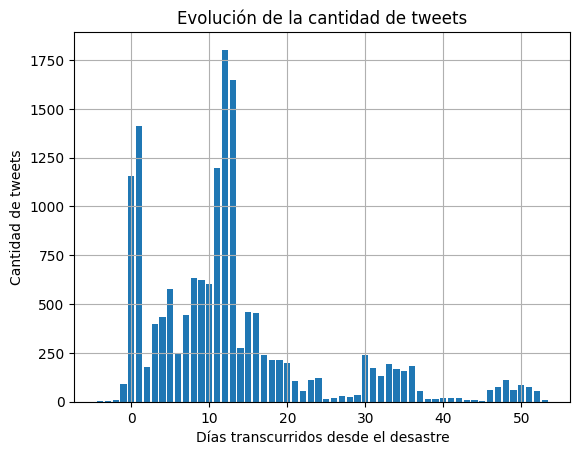

In [15]:
df_con_nan = df_con_nan[df_con_nan["tdd"] > -5]
 #Supongamos que tienes un DataFrame llamado df con las columnas 'tdd' y 'tweet_count'
# donde 'tdd' representa los días transcurridos y 'tweet_count' es la cantidad de tweets
tweet_counts = df_con_nan['tdd'].value_counts().sort_index()

# Crear el gráfico de barras
plt.bar(tweet_counts.index, tweet_counts.values)


# Personalizar el gráfico
plt.title('Evolución de la cantidad de tweets')
plt.xlabel('Días transcurridos desde el desastre')
plt.ylabel('Cantidad de tweets')
plt.grid(True)

# Mostrar el gráfico
plt.show()

#### Contando valores

In [19]:
count_retweet_not_zero = len(df[(df['retweet_count'] >= 1)])
count_favorite_not_zero = len(df[(df['favorite_count'] >= 1)])
reply_counts = len(df[(df['reply_count'] >= 1)])
quote_counts = len(df[(df['quote_count'] >= 1)])

# Contar la cantidad de tweets con retweet_count igual a 0
count_retweet_zero = len(df[df['retweet_count'] == 0])

# Contar la cantidad de tweets con favorite_count igual a 0
count_favorite_zero = len(df[df['favorite_count'] == 0])

# Contar la cantidad de tweets con reply counts = 0
reply_counts_zero = len(df[df['reply_count'] == 0])

# Contar la cantidad de tweets con reply counts = 0
quote_counts_zero = len(df[df['quote_count'] == 0])

# Contar la cantidad de tweets con is_quote_status = True
count_quote_true = len(df[df['is_quote_status'] == True])

# Contar la cantidad de tweets con is_quote_status = False
count_quote_false = len(df[df['is_quote_status'] == False])

# Contar la cantidad de tweets con possibly_sensitive = True
count_sensitive_true = len(df[df['possibly_sensitive'] == True])

# Contar la cantidad de tweets con possibly_sensitive = False
count_sensitive_false = len(df[df['possibly_sensitive'] == False])

print("Dataframe que contiene las columnas text_human")
print("")
print("Cantidad de tweets con retweet_count > 1:", count_retweet_not_zero)
print("Cantidad de tweets sin retweet_count:", count_retweet_zero)
print("Cantidad de tweets con favorite_count > 1:", count_favorite_not_zero)
print("Cantidad de tweets sin favorite_count:", count_favorite_zero)
print("Cantidad de tweets con reply_count > 1:", reply_counts)
print("Cantidad de tweets sin reply_count:", reply_counts_zero)
print("Cantidad de tweets con quote_count > 1:", quote_counts)
print("Cantidad de tweets sin quote_count:", quote_counts_zero)
print("Cantidad de tweets con is_quote_status = True:", count_quote_true)
print("Cantidad de tweets con is_quote_status = False:", count_quote_false)
print("Cantidad de tweets con possibly_sensitive = True:", count_sensitive_true)
print("Cantidad de tweets con possibly_sensitive = False:", count_sensitive_false)

print("")
print(f"Hay un {round((count_retweet_zero / (count_retweet_zero+count_retweet_not_zero))*100,2)} % de los tweets sin favoritos")
print(f"Hay un {round((count_favorite_zero / (count_favorite_zero+count_favorite_not_zero)) *100,2)} % de los tweets sin RTs")
print(f"Hay un {round((reply_counts_zero / (reply_counts_zero+reply_counts))*100,2)} % de los tweets sin respuestas(?)")
print(f"Hay un {round((quote_counts_zero / (quote_counts_zero+quote_counts)) *100,2)} % de los tweets sin citados")
print(f"Hay un {round((count_quote_false / (count_quote_false+count_quote_true))*100,2)} % de los tweets no citados")
print(f"Hay un {round((count_sensitive_false / (count_sensitive_false+count_sensitive_true)) *100,2)} % de los tweets no sensibles")


Dataframe que contiene las columnas text_human

Cantidad de tweets con retweet_count > 1: 1
Cantidad de tweets sin retweet_count: 13898
Cantidad de tweets con favorite_count > 1: 0
Cantidad de tweets sin favorite_count: 13899
Cantidad de tweets con reply_count > 1: 0
Cantidad de tweets sin reply_count: 13703
Cantidad de tweets con quote_count > 1: 0
Cantidad de tweets sin quote_count: 13704
Cantidad de tweets con is_quote_status = True: 91
Cantidad de tweets con is_quote_status = False: 13807
Cantidad de tweets con possibly_sensitive = True: 110
Cantidad de tweets con possibly_sensitive = False: 13789

Hay un 99.99 % de los tweets sin favoritos
Hay un 100.0 % de los tweets sin RTs
Hay un 100.0 % de los tweets sin respuestas(?)
Hay un 100.0 % de los tweets sin citados
Hay un 99.35 % de los tweets no citados
Hay un 99.21 % de los tweets no sensibles


In [18]:
count_retweet_not_zero = len(df_con_nan[(df_con_nan['retweet_count'] >= 1)])
count_favorite_not_zero = len(df_con_nan[(df_con_nan['favorite_count'] >= 1)])
reply_counts = len(df_con_nan[(df_con_nan['reply_count'] >= 1)])
quote_counts = len(df_con_nan[(df_con_nan['quote_count'] >= 1)])

# Contar la cantidad de tweets con retweet_count igual a 0
count_retweet_zero = len(df_con_nan[df_con_nan['retweet_count'] == 0])

# Contar la cantidad de tweets con favorite_count igual a 0
count_favorite_zero = len(df_con_nan[df_con_nan['favorite_count'] == 0])

# Contar la cantidad de tweets con reply counts = 0
reply_counts_zero = len(df_con_nan[df_con_nan['reply_count'] == 0])

# Contar la cantidad de tweets con reply counts = 0
quote_counts_zero = len(df_con_nan[df_con_nan['quote_count'] == 0])

# Contar la cantidad de tweets con is_quote_status = True
count_quote_true = len(df_con_nan[df_con_nan['is_quote_status'] == True])

# Contar la cantidad de tweets con is_quote_status = False
count_quote_false = len(df_con_nan[df_con_nan['is_quote_status'] == False])

# Contar la cantidad de tweets con possibly_sensitive = True
count_sensitive_true = len(df_con_nan[df_con_nan['possibly_sensitive'] == True])

# Contar la cantidad de tweets con possibly_sensitive = False
count_sensitive_false = len(df_con_nan[df_con_nan['possibly_sensitive'] == False])

print("Dataframe que tiene tweets sin las columnas text_human")
print("")
print("Cantidad de tweets con retweet_count > 1:", count_retweet_not_zero)
print("Cantidad de tweets sin retweet_count:", count_retweet_zero)
print("Cantidad de tweets con favorite_count > 1:", count_favorite_not_zero)
print("Cantidad de tweets sin favorite_count:", count_favorite_zero)
print("Cantidad de tweets con reply_count > 1:", reply_counts)
print("Cantidad de tweets sin reply_count:", reply_counts_zero)
print("Cantidad de tweets con quote_count > 1:", quote_counts)
print("Cantidad de tweets sin quote_count:", quote_counts_zero)
print("Cantidad de tweets con is_quote_status = True:", count_quote_true)
print("Cantidad de tweets con is_quote_status = False:", count_quote_false)
print("Cantidad de tweets con possibly_sensitive = True:", count_sensitive_true)
print("Cantidad de tweets con possibly_sensitive = False:", count_sensitive_false)

print("")
print(f"Hay un {round((count_retweet_zero / (count_retweet_zero+count_retweet_not_zero))*100,2)} % de los tweets sin favoritos")
print(f"Hay un {round((count_favorite_zero / (count_favorite_zero+count_favorite_not_zero)) *100,2)} % de los tweets sin RTs")
print(f"Hay un {round((reply_counts_zero / (reply_counts_zero+reply_counts))*100,2)} % de los tweets sin respuestas(?)")
print(f"Hay un {round((quote_counts_zero / (quote_counts_zero+quote_counts)) *100,2)} % de los tweets sin citados")
print(f"Hay un {round((count_quote_false / (count_quote_false+count_quote_true))*100,2)} % de los tweets no citados")
print(f"Hay un {round((count_sensitive_false / (count_sensitive_false+count_sensitive_true)) *100,2)} % de los tweets no sensibles")

Dataframe que tiene tweets sin las columnas text_human

Cantidad de tweets con retweet_count > 1: 2068
Cantidad de tweets sin retweet_count: 13898
Cantidad de tweets con favorite_count > 1: 1719
Cantidad de tweets sin favorite_count: 14247
Cantidad de tweets con reply_count > 1: 860
Cantidad de tweets sin reply_count: 14793
Cantidad de tweets con quote_count > 1: 853
Cantidad de tweets sin quote_count: 14801
Cantidad de tweets con is_quote_status = True: 91
Cantidad de tweets con is_quote_status = False: 15874
Cantidad de tweets con possibly_sensitive = True: 121
Cantidad de tweets con possibly_sensitive = False: 15845

Hay un 87.05 % de los tweets sin favoritos
Hay un 89.23 % de los tweets sin RTs
Hay un 94.51 % de los tweets sin respuestas(?)
Hay un 94.55 % de los tweets sin citados
Hay un 99.43 % de los tweets no citados
Hay un 99.24 % de los tweets no sensibles


In [22]:
def hist_interaction(df):
    print(df[['quote_count', 'favorite_count', 'reply_count', 'retweet_count']].describe())
    new_df = df[df['retweet_count'] > 50]
    new_df[['quote_count', 'favorite_count', 'reply_count', 'retweet_count']].hist()



        quote_count  favorite_count   reply_count  retweet_count
count  15654.000000    15966.000000  15653.000000   15966.000000
mean       2.321771       37.503320      1.467386      19.372103
std       59.565969      834.147438     36.812597     459.675644
min        0.000000        0.000000      0.000000       0.000000
25%        0.000000        0.000000      0.000000       0.000000
50%        0.000000        0.000000      0.000000       0.000000
75%        0.000000        0.000000      0.000000       0.000000
max     4010.000000    51726.000000   3797.000000   36840.000000


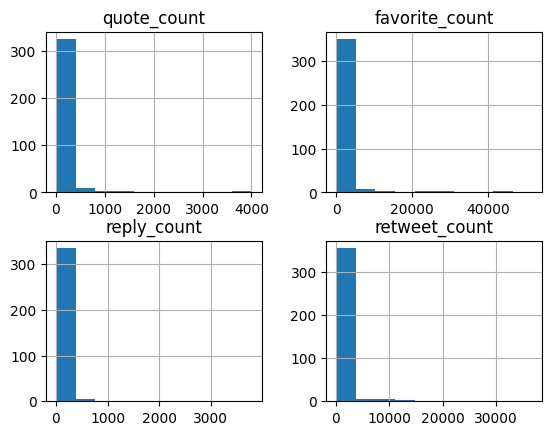

In [24]:
hist_interaction(df_con_nan)

       quote_count  favorite_count  reply_count  retweet_count
count      13704.0         13899.0      13703.0   13899.000000
mean           0.0             0.0          0.0       0.000072
std            0.0             0.0          0.0       0.008482
min            0.0             0.0          0.0       0.000000
25%            0.0             0.0          0.0       0.000000
50%            0.0             0.0          0.0       0.000000
75%            0.0             0.0          0.0       0.000000
max            0.0             0.0          0.0       1.000000


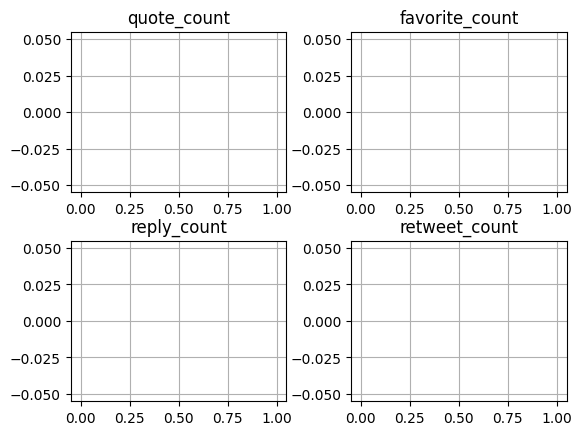

In [25]:
hist_interaction(df)

Se procede a analizar los tweets si son informativos y si son humanitarios. Se separan en grupos según el valor 'conf'. Si 'conf' es 1, se grafican los valores como tal. Si 'conf' es menor a 1, se gráfica junto al promedio de conf. Aqui solo es posible usar el dataframe con la columna text_human sin Nan



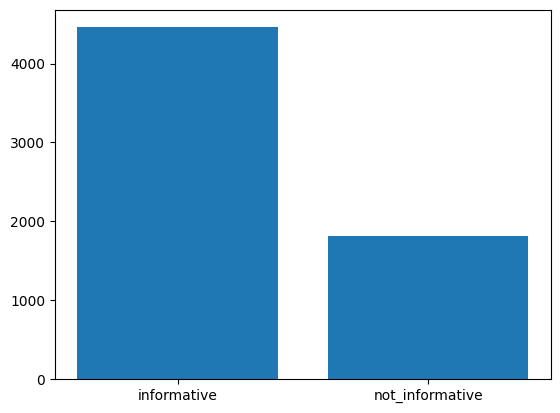

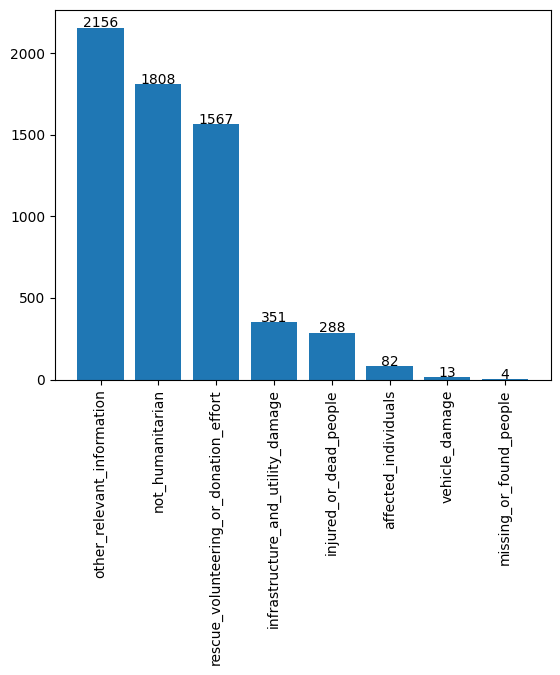

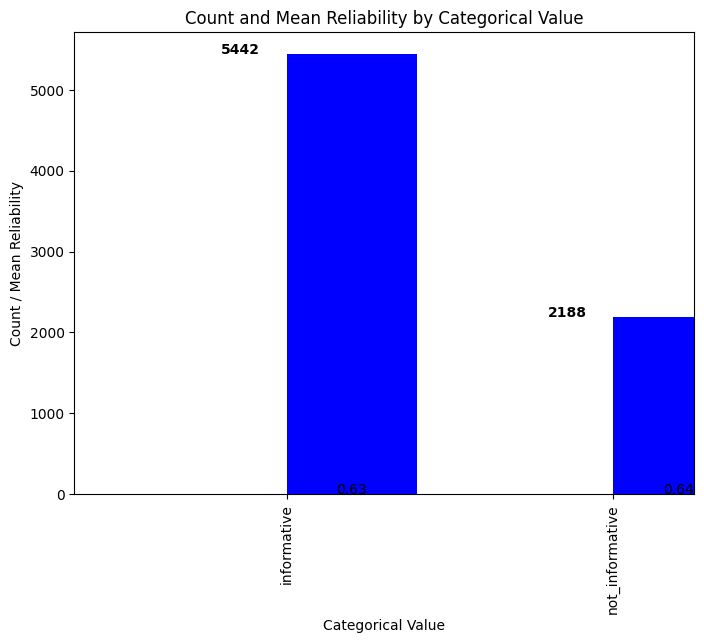

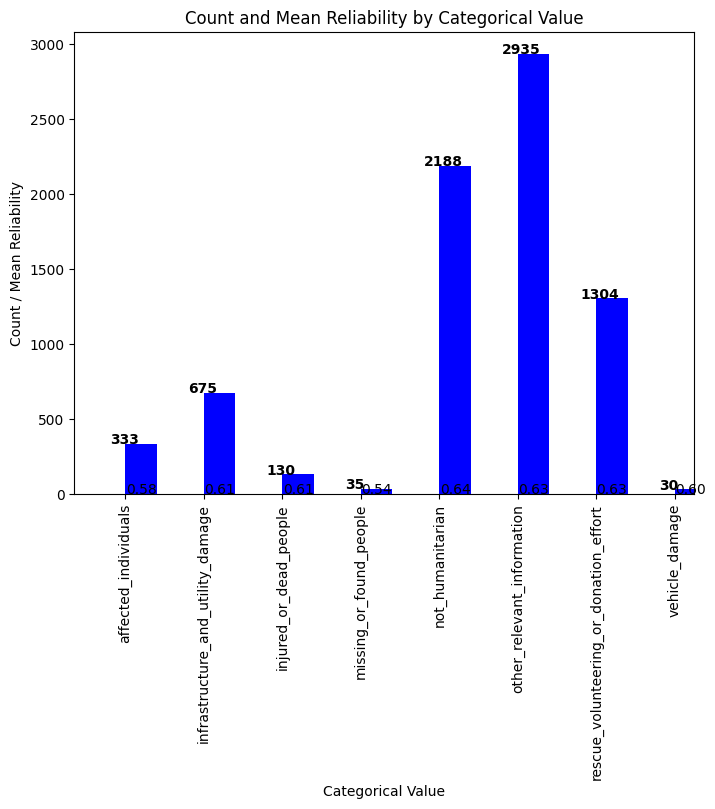

In [31]:
def info_and_human(df):
    
    #se copia la dataframe
    df_info = df.copy()
    df_human = df.copy()

    #se borran los archivos NaN correspondientes
    df_info = df_info[df_info['text_info'].notna()]
    df_info = df_info[df_info['text_info_conf'].notna()]
    df_human = df_human[df_human['text_human'].notna()]
    df_human = df_human[df_human['text_human_conf'].notna()]

    #se reinicia la index si necesario
    df_info.reset_index(inplace=True, drop=True)
    df_human.reset_index(inplace=True, drop=True)

    #se crea nueva id según index
    df_info["new_id"] = df_info.index
    df_human["new_id"] = df_human.index

    
    #se crean dataframes para separar conf=1 con conf<1
    info_confiable = df_info[["new_id", "id", "text_info", "text_info_conf"]].copy()
    info_casi_confiable = df_info[["new_id", "id", "text_info", "text_info_conf"]].copy()

    wanted = []
    not_wanted = []

    i = 0
    while i < info_confiable.shape[0]:
        #print(info_confiable["text_info_conf"][i])
        if info_confiable["text_info_conf"][i] < 1:
            not_wanted.append(info_confiable["new_id"][i])
        else:
            wanted.append(info_confiable["new_id"][i])
        i += 1


    for j in not_wanted:
        info_confiable = info_confiable.drop(info_confiable[info_confiable["new_id"]==j].index)

    for k in wanted:
        info_casi_confiable = info_casi_confiable.drop(info_casi_confiable[info_casi_confiable["new_id"]==k].index)


    #se crean dataframes para separar conf=1 con conf<1
    human_confiable = df_human[["new_id", "id", "text_human", "text_human_conf"]].copy()
    human_casi_confiable = df_human[["new_id", "id", "text_human", "text_human_conf"]].copy()

    hwanted = []
    not_hwanted = []

    i = 0
    while i < human_confiable.shape[0]:
        #print(info_confiable["text_info_conf"][i])
        if human_confiable["text_human_conf"][i] < 1:
            not_hwanted.append(human_confiable["new_id"][i])
        else:
            hwanted.append(human_confiable["new_id"][i])
        i += 1


    for j in not_hwanted:
        human_confiable = human_confiable.drop(human_confiable[human_confiable["new_id"]==j].index)

    for k in hwanted:
        human_casi_confiable = human_casi_confiable.drop(human_casi_confiable[human_casi_confiable["new_id"]==k].index)


    valores_info_confiable = info_confiable["text_info"].value_counts()

    plt.bar(valores_info_confiable.index, valores_info_confiable.values)

    plt.xlabel("")
    plt.ylabel("")
    plt.title("")

    plt.show()

    valores_human_confiable = human_confiable["text_human"].value_counts()

    plt.bar(valores_human_confiable.index, valores_human_confiable.values)

    for i, v in enumerate(valores_human_confiable.values):
        plt.text(i, v + 1, str(v), ha="center")

    plt.xlabel("")
    plt.ylabel("")
    plt.title("")

    plt.xticks(rotation=90)

    plt.show()


    # calculate counts and means
    counts = info_casi_confiable['text_info'].value_counts().sort_index()
    means = info_casi_confiable.groupby('text_info')['text_info_conf'].mean().sort_index()

    # plot the bar chart
    fig, ax = plt.subplots(figsize=(8,6))
    counts.plot(kind='bar', color='blue', width=0.4, position=0, ax=ax)
    means.plot(kind='bar', color='red', width=0.4, position=1, ax=ax)

    # add labels
    ax.set_xlabel('Categorical Value')
    ax.set_ylabel('Count / Mean Reliability')
    ax.set_title('Count and Mean Reliability by Categorical Value')

    # add value labels
    for i, count in enumerate(counts):
        ax.text(i-0.2, count+0.1, str(count), color='black', fontweight='bold')
    for i, mean in enumerate(means):
        ax.text(i+0.2, mean+0.02, f'{mean:.2f}', color='black', ha='center')

    # calculate counts and means
    counts = human_casi_confiable['text_human'].value_counts().sort_index()
    means = human_casi_confiable.groupby('text_human')['text_human_conf'].mean().sort_index()

    # plot the bar chart
    fig, ax = plt.subplots(figsize=(8,6))
    counts.plot(kind='bar', color='blue', width=0.4, position=0, ax=ax)
    means.plot(kind='bar', color='red', width=0.4, position=1, ax=ax)

    # add labels
    ax.set_xlabel('Categorical Value')
    ax.set_ylabel('Count / Mean Reliability')
    ax.set_title('Count and Mean Reliability by Categorical Value')

    # add value labels
    for i, count in enumerate(counts):
        ax.text(i-0.2, count+0.1, str(count), color='black', fontweight='bold')
    for i, mean in enumerate(means):
        ax.text(i+0.2, mean+0.02, f'{mean:.2f}', color='black', ha='center')

info_and_human(df)

In [57]:
print(df_con_nan["json_name"].unique())

['california_wildfires' 'hurricane_harvey' 'hurricane_irma'
 'hurricane_maria' 'iraq_iran_earthquake' 'mexico_earthquake'
 'srilanka_floods']


In [61]:
def contando_valores_desastres(df):
    desastres = df["json_name"].unique()
    for d in desastres:
        tweets = df[df["json_name"] == d].shape
        print(f"En {d} hay un total de {tweets[0]} tweets")
   

In [64]:
shape_df = df.shape
shape_df_con_nan = df_con_nan.shape
print(f"hay en df : {shape_df[0]} filas")
print(f"hay en df_con_nan : {shape_df_con_nan[0]} filas")
print("")
print("df")
contando_valores_desastres(df)
print("")
print("df_con_nan")
contando_valores_desastres(df_con_nan)

hay en df : 13899 filas
hay en df_con_nan : 15966 filas

df
En california_wildfires hay un total de 1370 tweets
En hurricane_harvey hay un total de 3315 tweets
En hurricane_irma hay un total de 3407 tweets
En hurricane_maria hay un total de 3537 tweets
En iraq_iran_earthquake hay un total de 452 tweets
En mexico_earthquake hay un total de 1067 tweets
En srilanka_floods hay un total de 751 tweets

df_con_nan
En california_wildfires hay un total de 1475 tweets
En hurricane_harvey hay un total de 3958 tweets
En hurricane_irma hay un total de 4015 tweets
En hurricane_maria hay un total de 3984 tweets
En iraq_iran_earthquake hay un total de 496 tweets
En mexico_earthquake hay un total de 1227 tweets
En srilanka_floods hay un total de 811 tweets


#### Conteo de palabras

In [35]:
from wordcloud import WordCloud
from nltk.corpus import stopwords
import re
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
nltk.download('stopwords')

text_data = df['text'].str.split().tolist()
all_words = [word.lower() for sublist in text_data for word in sublist]

def clean_and_tokenize2(text):
    # Eliminar caracteres especiales y hashtags pegados a palabras
    cleaned_text = re.sub(r"[^\w\s]|(#\w+)", "", text)

    # Tokenizar el texto
    tokens = word_tokenize(cleaned_text.lower())

    # Eliminar stopwords en inglés y palabras adicionales
    stop_words = set(stopwords.words('english'))
    additional_stop_words = ['california', 'wildfires', 'hurricane', 'harvey', 'irma', 'maria', 'iraq', 
     'iran', 'earthquake', 'mexico', 'srilanka', 'floods','puerto','rico','us','texas','florida','texas','hurricanemaria',
     'hurricaneharvey','puertorico','mexicoearthquake','houston','wildfire','ricos','tornado' , 'storm','flood','fire','trump',
     'hurricanes','caribbean','flooding','disaster','irmas','tropical','harveys','st','amp']
    stop_words.update(additional_stop_words)

    # Agregar números a la lista de stopwords
    stop_words.update(additional_stop_words)
    stop_words.update(set(token for token in tokens if token.isdigit()))

    # Filtrar las palabras
    filtered_tokens = [token for token in tokens if token not in stop_words]

    return filtered_tokens



[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\steve\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\steve\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### df Completo

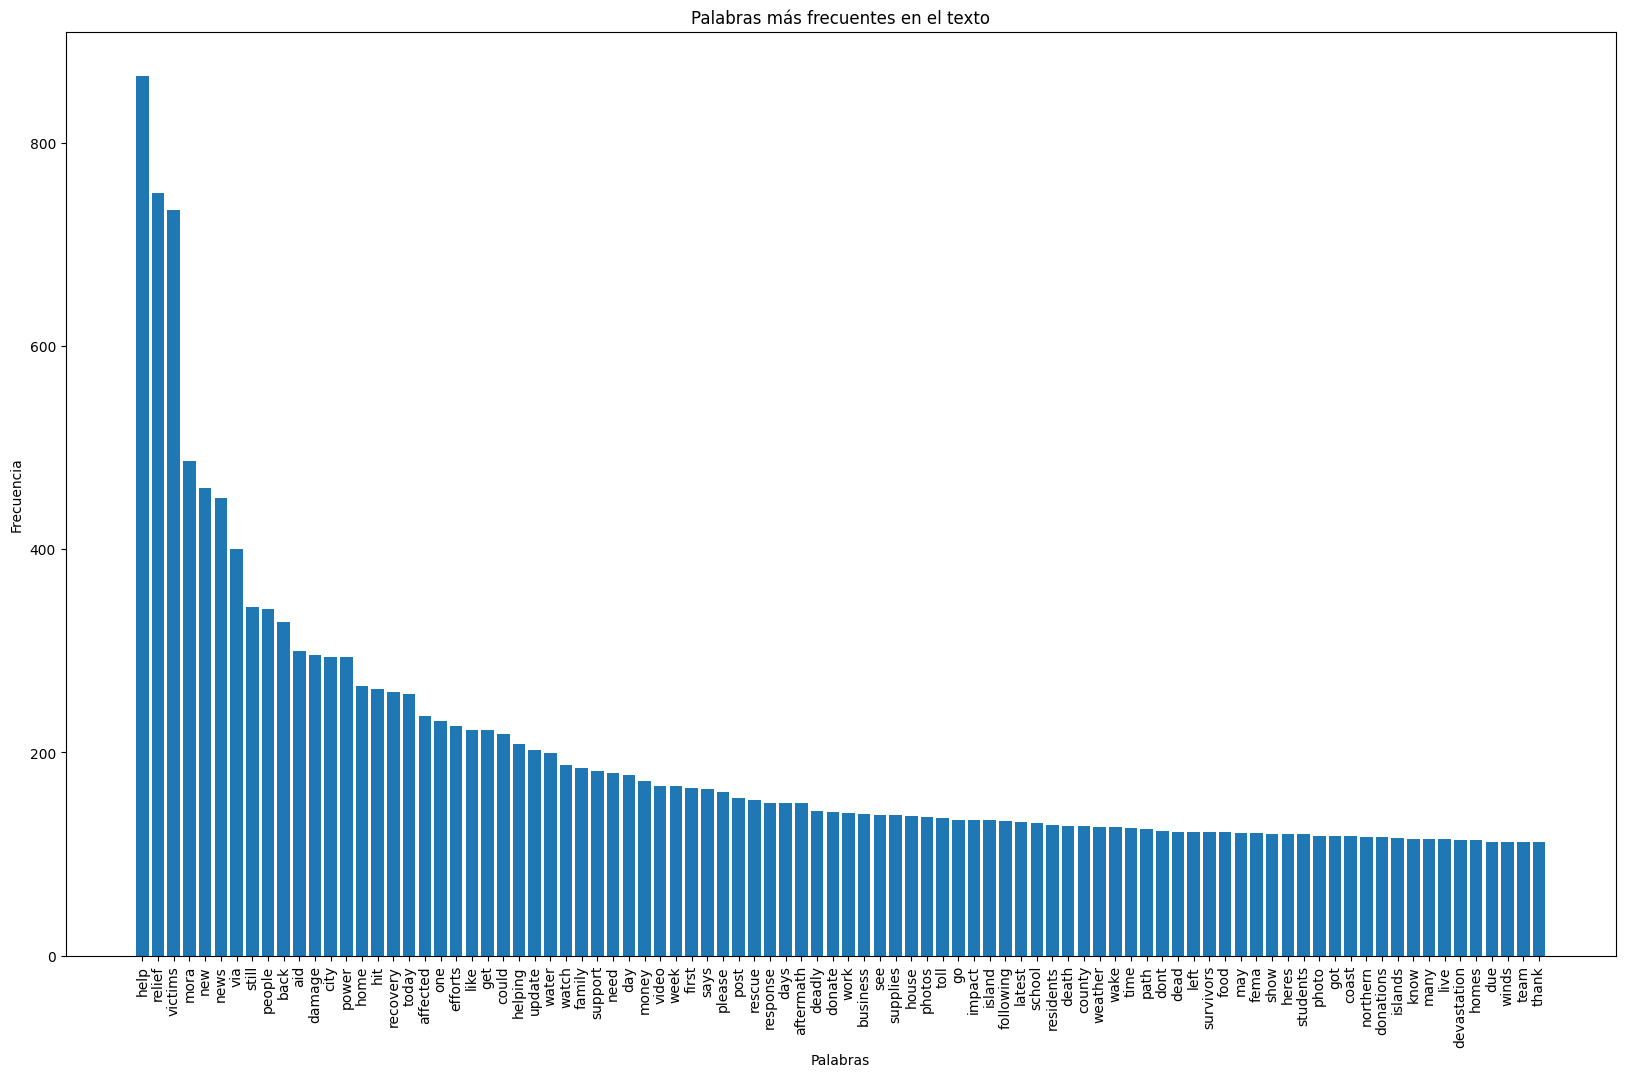

In [39]:
# Obtener las palabras y sus frecuencias en la columna "text"
words = df_con_nan['text'].apply(clean_and_tokenize2).explode()
word_counts = Counter(words)

# Obtener las palabras más frecuentes
top_words = word_counts.most_common(90)

# Crear el gráfico de barras
plt.figure(figsize=(20,12))
plt.bar(*zip(*top_words))
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.title('Palabras más frecuentes en el texto')
plt.xticks(rotation=90)
plt.show()

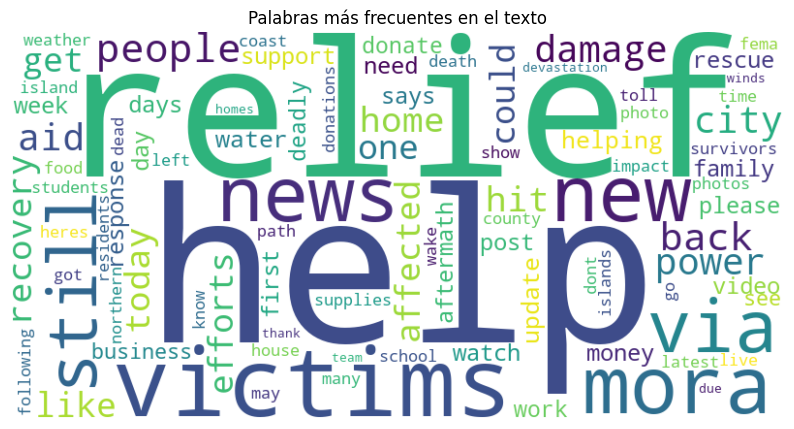

In [40]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(top_words))

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Palabras más frecuentes en el texto')
plt.show()

#### df Filtrado

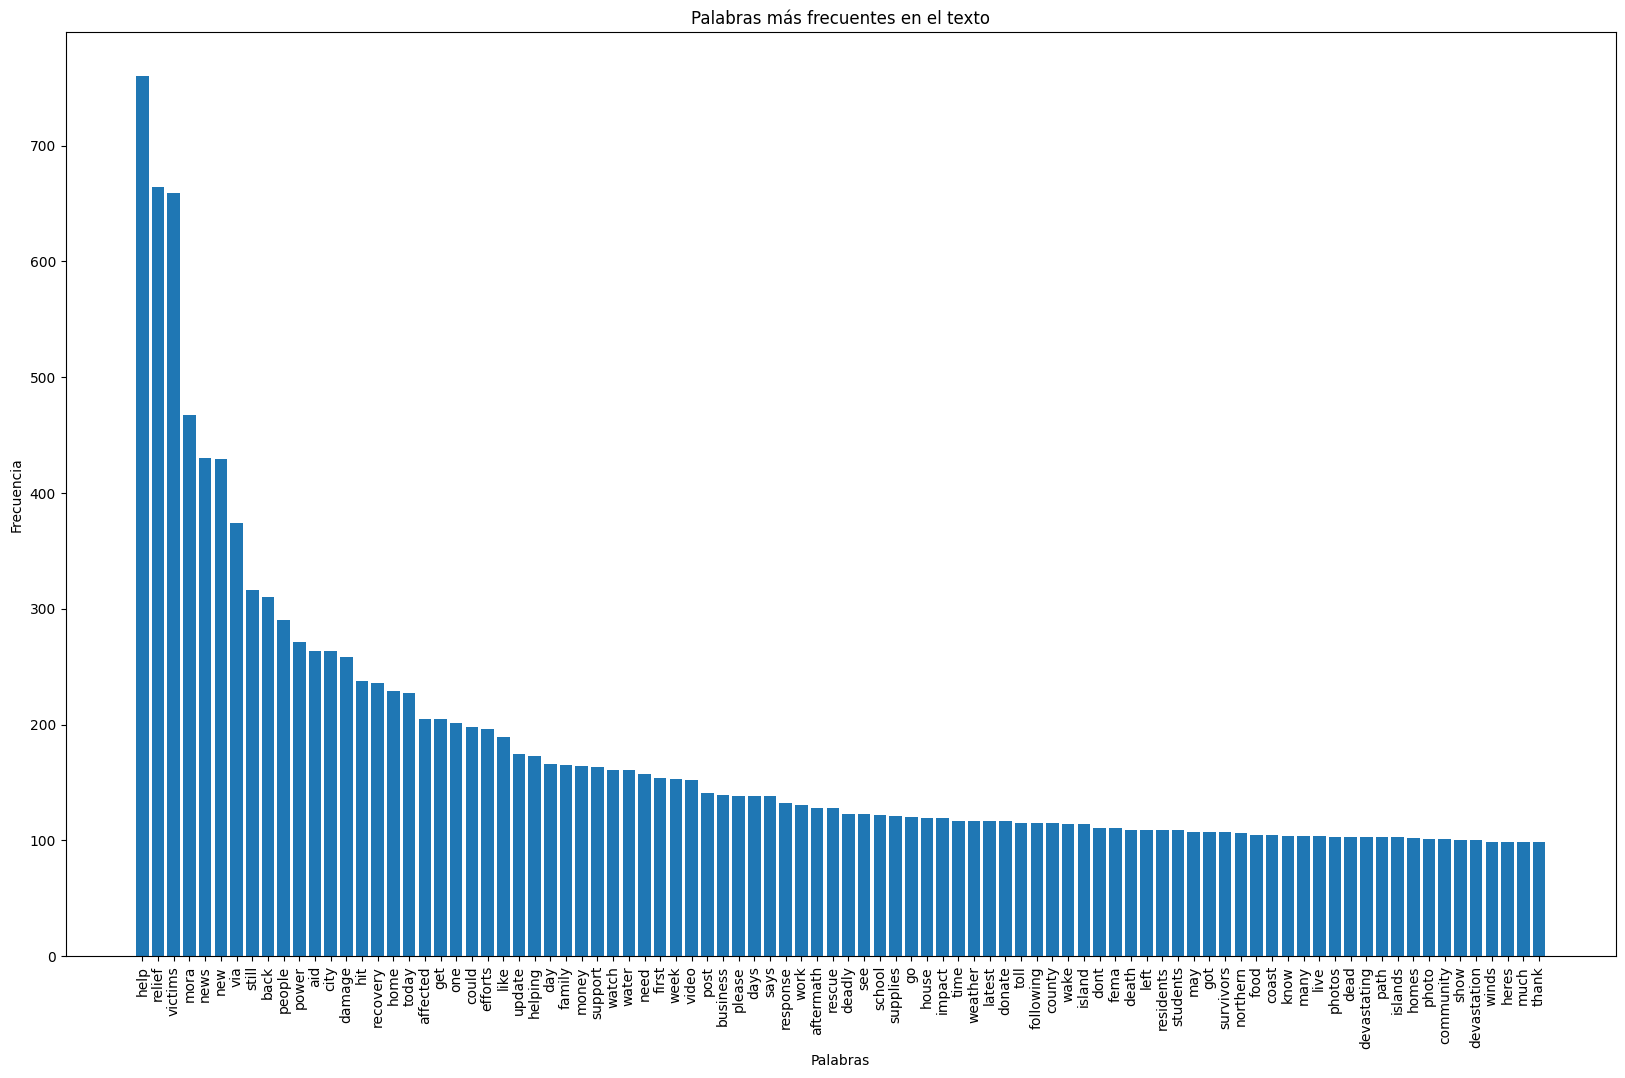

In [41]:
# Obtener las palabras y sus frecuencias en la columna "text"
words = df['text'].apply(clean_and_tokenize2).explode()
word_counts = Counter(words)

# Obtener las palabras más frecuentes
top_words = word_counts.most_common(90)

# Crear el gráfico de barras
plt.figure(figsize=(20,12))
plt.bar(*zip(*top_words))
plt.xlabel('Palabras')
plt.ylabel('Frecuencia')
plt.title('Palabras más frecuentes en el texto')
plt.xticks(rotation=90)
plt.show()

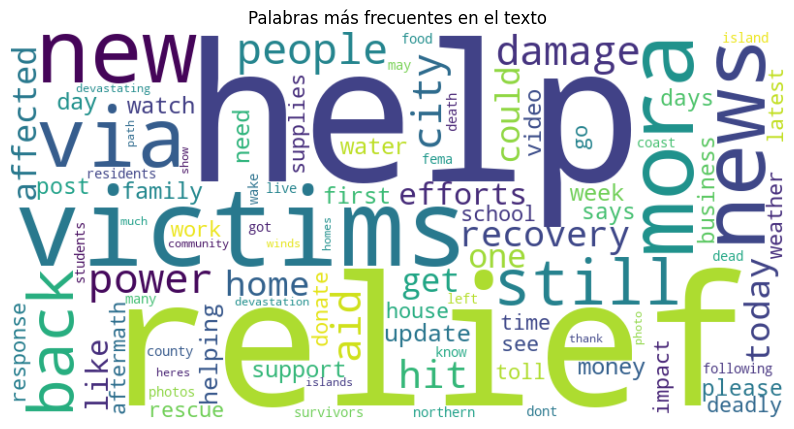

In [42]:
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(top_words))

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Palabras más frecuentes en el texto')
plt.show()

#### Tweets por fechas (dataframe completo)

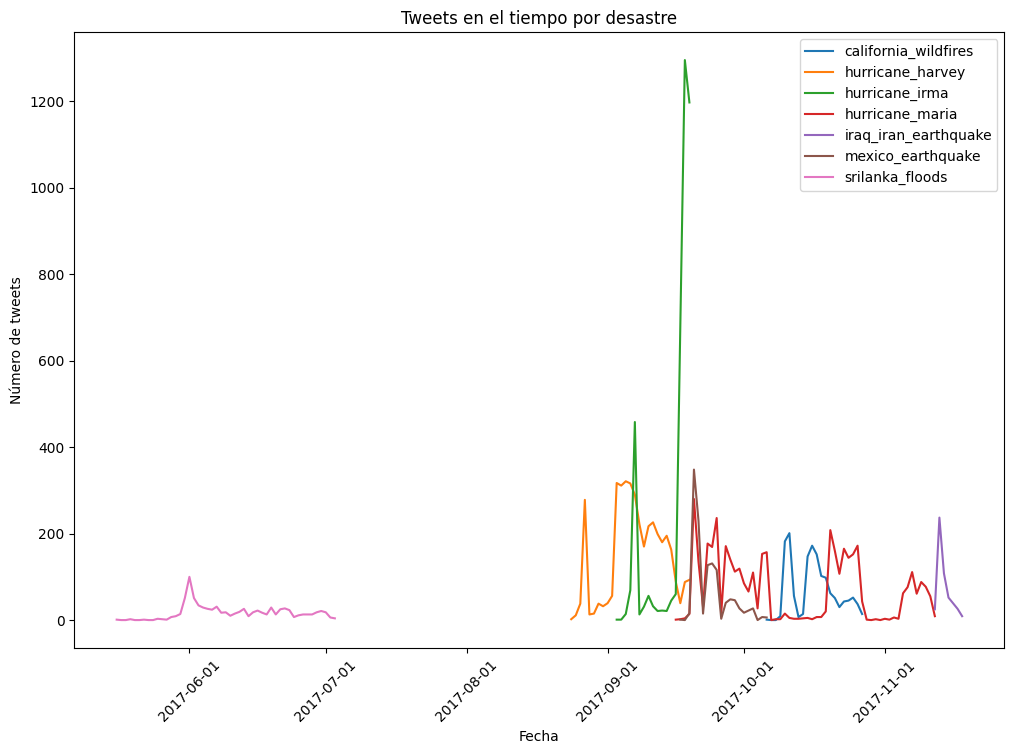

In [43]:
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.dates as mdates

# Convertir la columna 'created_at' a un objeto de fecha y hora
df_con_nan['created_at'] = pd.to_datetime(df_con_nan['created_at'], format='%a %b %d %H:%M:%S %z %Y')

# Configuración del gráfico
fig, ax = plt.subplots(figsize=(12, 8))

# Generar las líneas de tiempo para cada desastre
for desastre in df_con_nan['json_name'].unique():
    df_desastre = df_con_nan[df_con_nan['json_name'] == desastre]
    counts = df_desastre.groupby(pd.Grouper(key='created_at', freq='D')).size()
    ax.plot(counts.index, counts.values, label=desastre)

# Configurar etiquetas y título
ax.set_xlabel('Fecha')
ax.set_ylabel('Número de tweets')
ax.set_title('Tweets en el tiempo por desastre')

# Formatear las etiquetas del eje x como fechas legibles
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
ax.xaxis.set_major_locator(mdates.AutoDateLocator())

# Rotar las etiquetas del eje x para mayor legibilidad
plt.xticks(rotation=45)

# Agregar una leyenda
ax.legend()

# Mostrar el gráfico
plt.show()


#### Interacciones

In [44]:
tweet_counts = df_con_nan['json_name'].value_counts()
tweet_counts2 =df['json_name'].value_counts()
print(f"Cantidad de tweets con columnas NaN en text_human \n{tweet_counts}")
print()
print(f"Cantidad de tweets sin columnas NaN en text_human\n{tweet_counts2}")

Cantidad de tweets con columnas NaN en text_human 
json_name
hurricane_irma          4015
hurricane_maria         3984
hurricane_harvey        3958
california_wildfires    1475
mexico_earthquake       1227
srilanka_floods          811
iraq_iran_earthquake     496
Name: count, dtype: int64

Cantidad de tweets sin columnas NaN en text_human
json_name
hurricane_maria         3537
hurricane_irma          3407
hurricane_harvey        3315
california_wildfires    1370
mexico_earthquake       1067
srilanka_floods          751
iraq_iran_earthquake     452
Name: count, dtype: int64


In [46]:
interactions = df_con_nan.groupby('json_name')[['retweet_count', 'favorite_count', 'reply_count','quote_count']].mean()
print(f"Promedio de interacciones por desastre (df_con_nan)\n{interactions}")
interactions2 = df.groupby('json_name')[['retweet_count', 'favorite_count', 'reply_count','quote_count']].mean()
print(f"Promedio de interacciones por desastre (df filtrado)\n{interactions2}")

Promedio de interacciones por desastre (df_con_nan)
                      retweet_count  favorite_count  reply_count  quote_count
json_name                                                                    
california_wildfires       1.818305        1.951864     0.218305     0.178983
hurricane_harvey          26.413340       55.843861     2.128908     1.729567
hurricane_irma            30.462267       58.823661     2.124533     5.494147
hurricane_maria           15.547942       28.289157     1.411145     1.606928
iraq_iran_earthquake       2.338710        2.125000     0.252016     0.229839
mexico_earthquake         12.612877       18.971475     0.495922     0.977995
srilanka_floods            1.459926        2.041924     0.000000     0.000000
Promedio de interacciones por desastre (df filtrado)
                      retweet_count  favorite_count  reply_count  quote_count
json_name                                                                    
california_wildfires       0.000000  

### Clustering buscando grupos

       favorite_count  retweet_count  reply_count  quote_count  tdd  magnitud
0                   0              0          0.0          0.0    0     0.078
1                   7              5          0.0          4.0    0     0.078
2                 289            479          9.0         25.0   -1     0.078
3                 228            216         19.0         18.0    0     0.078
4                   0              0          0.0          0.0    0     0.078
...               ...            ...          ...          ...  ...       ...
15219               0              0          0.0          0.0   16     0.073
15220               0              0          0.0          0.0   16     0.073
15221               0              0          0.0          0.0   16     0.073
15222               0              0          0.0          0.0   16     0.073
15223               0              0          0.0          0.0   16     0.073

[14842 rows x 6 columns]


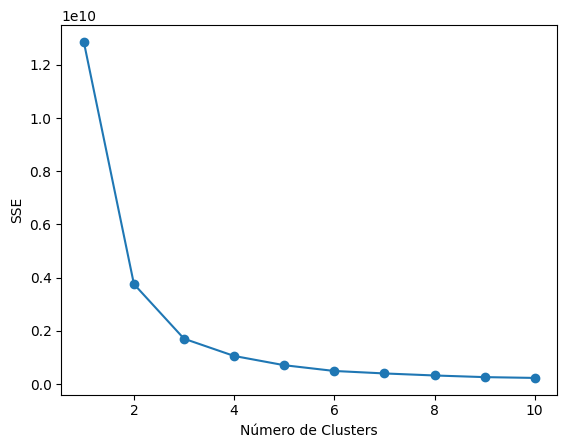

In [47]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

mag = {"mexico_earthquake":0.073,
       "hurricane_harvey":0.06,
       "hurricane_irma":0.06,
       "iraq_iran_earthquake":0.107,
       "hurricane_maria":0.046,
       "srilanka_floods":0.03,
       "california_wildfires":0.078}

desastres = ['california_wildfires','hurricane_harvey','hurricane_maria','hurricane_irma','iraq_iran_earthquake','mexico_earthquake']



df2 = df_con_nan.copy()
magnitud = []
for row in df2['json_name']:
    magnitud.append(mag[row])
df2['magnitud'] = magnitud
df2 = df2[df2['json_name'] != 'srilanka_floods']
df2 = df2.select_dtypes(['number'])
df2.drop(["text_human_conf","text_info_conf","id"],axis='columns',inplace=True)

df2 =  df2.dropna()
print(df2)

SSE = []
numClusters = list(range(1, 11))
for k in numClusters:
    k_means = KMeans(n_clusters=k, n_init=10, random_state=1)
    k_means.fit(df2)
    SSE.append(k_means.inertia_)

plt.plot(numClusters, SSE, marker="o")
plt.xlabel('Número de Clusters')
plt.ylabel('SSE')
plt.show()

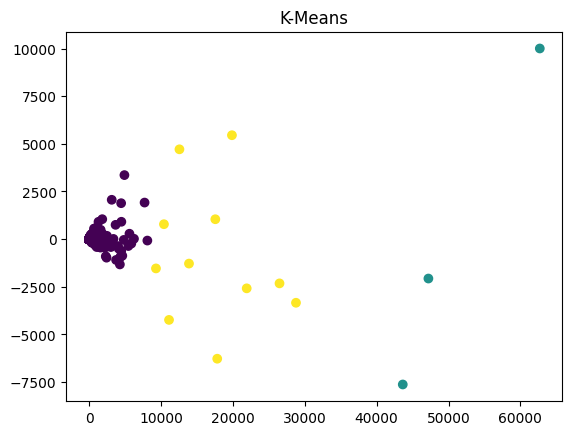

In [48]:
k = 3

from sklearn.decomposition import PCA

kmeans = KMeans(n_clusters=3, max_iter=50, random_state=1, n_init='auto')
kmeans.fit(df2)
pca = PCA(n_components=2).fit(df2)
df_pca = pca.transform(df2) 

#scatter para cada caso


plt.scatter(df_pca[:, 0], df_pca[:, 1], c=kmeans.labels_)
plt.title("K-Means")
plt.show()

#### Centroides 

In [49]:
centroids = kmeans.cluster_centers_
pd.DataFrame(centroids, columns=df2.columns)

,favorite_count,retweet_count,reply_count,quote_count,tdd,magnitud
0,15.944902,8.721068,0.915700,1.413947,12.572835,0.060678
1,45792.666667,22862.333333,1807.000000,1157.666667,4.666667,0.055333
2,15875.363636,6813.272727,360.909091,1082.363636,3.545455,0.058727


- Grupo 1: Tweets sin mucha relevancia/interacciones, donde son los que mas tweets mas antiguos o lejanos del desastre
- Grupo 2: Tweets muy 'virales', con fechas cercanas al desastre
- Grupo 3: Tweets con ciertas interacciones, con fechas cercanas al desastre 

In [50]:
from sklearn.metrics import silhouette_score

print("Dataset kmeans \t", silhouette_score(df2, kmeans.labels_))

Dataset kmeans 	 0.9965363813924422
